# Desafío 3 - Procesamiento del Lenguaje Natural I
### Carrera de Especialización en Inteligencia Artificial - Cohorte 17
##### Docentes: Rodrigo Cárdenas / Nicolás  Vattuone
#### Autor: Alejandro Lloveras

***NOTA PARA EJECUCIÓN:***
- Cada punto de la resolución debe ejecutarse de forma unitaria: se inicializa ejecutando la sección 'Indotrucción' y luego la sección del punto correspondiente.

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [ ]:
DATASET_ROOT = '../../clase_2/ejercicios/'

In [ ]:
import random
import io
import os
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Información del dataset
Para este desafío trabajaré con un dataset de cosecha propia, compuesto por +3700 letras de tango.

Para su construcción realicé scraping del sitio *todotango.com*
> https://www.todotango.com/musica/obras/letras/-/7/Tango/

### Descripción del dataset

- Compuesto por **3.769 elementos** *(canciones)*
- Idioma Español -> Variante Rioplatense -> Argot lunfardo
- Cada letra se encuentra almacenada en un archivo .TXT dentro de la carpeta 'lyrics' *(cod. utf-8)*
- Almacenamiento 15,4 MB

In [129]:
# Cargamos corpus del CSV
corpus = pd.read_csv(f'{DATASET_ROOT}corpus.csv', encoding='utf-8')

In [130]:
corpus

,line
0,A río revuelto se mueren los peces
1,Los cielos se incendian el pasto no crece
2,"La vida no vive, el sol no amanece"
3,"A río revuelto, quién gana y quién pierde"
4,A río revuelto no llama el amigo
...,...
112049,¿De qué sirvió lograr mis ambiciones
112050,si mis ensueños ya los perdí?...
112051,"¡Ya no sé querer,"
112052,ni puedo ser feliz


# Pre-procesamiento

### Elegir el tamaño del contexto

In [132]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [133]:
# cada verso lo guardamos en una lista
text = list(corpus['line'])
text

['A río revuelto se mueren los peces',
 'Los cielos se incendian el pasto no crece',
 'La vida no vive, el sol no amanece',
 'A río revuelto, quién gana y quién pierde',
 'A río revuelto no llama el amigo',
 'Se angustia el vecino cerrando el postigo',
 'La noche desierta, no tiene testigos',
 'Y así cada uno, se mira su ombligo',
 'A río revuelto se secan las flores',
 'Se pudre el futuro, se van los mejores',
 'Y empiezan a oírse a los predicadores',
 'Quién gana y quién pierde a río revuelto',
 'Quien gana y quién pierde, quien gana y quién pierde',
 'A río revuelto es moneda corriente',
 'Tomar al mediocre por inteligente',
 'Que al más indecente lo elija la gente',
 'A río revuelto quién gana y quién pierde',
 'A río revuelto se frota las manos',
 'La sucia moral del dinero profano',
 'Poniéndole precio a los seres humanos',
 'Igual que en la arena del circo romano',
 'A río revuelto, quién gana y quién pierde',
 'Si el miedo anda suelto y el hambre, nos muerde',
 'Si el sol del f

In [ ]:
length = len(text)
length

112054

Luego de varios intentos de entrenamiento interrumpidos por un error OOM (por superar la RAM disponible en Colab), se decidió reducir el tamaño del corpus para reducir la cantidad de memoria necesaria.

In [ ]:
# Se acota el tamaño del corpus por limitaciones de hardware
short_text = text[:round(length*0.5)]
len(short_text)

56027

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in short_text]

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([1.0510e+03, 8.9490e+03, 2.1800e+04, 1.5831e+04, 4.3640e+03,
        3.3110e+03, 6.3300e+02, 6.6000e+01, 1.0000e+01, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ,
        19.8, 21.6, 23.4, 25.2, 27. , 28.8, 30.6, 32.4, 34.2, 36. ]),
 <BarContainer object of 20 artists>)

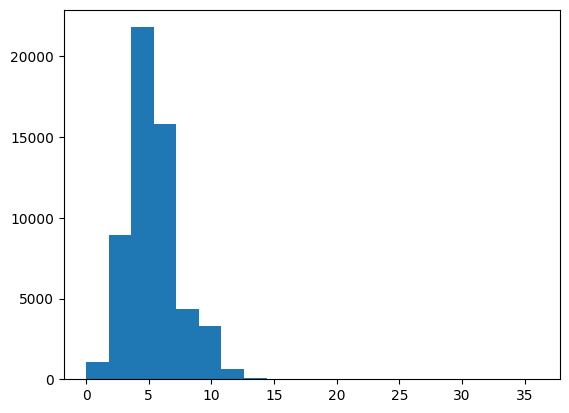

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto.

# En este caso es un percentil, pero otros criterios también pueden ser válidos.
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 7


###  Tokenizar

In [ ]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences[0]

[8, 363, 2107, 15, 1972, 17, 4972]

In [ ]:
segmented_sentences[0]

['a', 'río', 'revuelto', 'se', 'mueren', 'los', 'peces']

### Organizando y estructurando el dataset

Se divide el dataset en train/test splits a partir de la variable `tokenized_sentences` con los versos tokenizados.

In [141]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Se dividen las oraciones con un tamaño mayor al contexto máximo definido en el paso anterior.

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:
  # si la secuencia tiene más términos que el tamaño de contexto máximo, armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [ ]:
len(tok_sent)

50481

Se procede a aplicar Data augmentation.

In [ ]:
tok_sent_augm = []

for sent in tok_sent:
  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [145]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(229056, 8)

Para reducir el uso de RAM de forma innecesaria, se verifica el tipo de datos necesario para representar adecuadamente los parámetros del dataset.

In [ ]:
import sys
original_size = sys.getsizeof(train_seqs)
print(f"El tamaño de la variable es: {original_size} bytes")

El tamaño de la variable es: 7329920 bytes


In [ ]:
# Verificamos el número máximo de valores
train_seqs.max()

np.int32(24544)

Se verifica que el valor máximo a representar es 35468, todos números positivos, por lo que no es necesitvo contar con signo negativo (uint).

| Característica | int32 | uint16 |
|---|---|---|
| **Tipo** | Entero con signo | Entero sin signo |
| **Tamaño** | 32 bits | 16 bits |
| **Rango** | -2,147,483,648 a 2,147,483,647 | 0 a 65,535 |

In [ ]:
# Dado que son todos valores positivos entre 0 y 35468
# puede representarse con uint16, liberando espacio en memoria
train_seqs = train_seqs.astype(np.uint16)

In [ ]:
new_size = sys.getsizeof(train_seqs)
print(f"El tamaño de la variable es: {new_size} bytes")
print(f"Reducción de espacio en memoria: {(new_size/original_size-1)*100:.2f}%")

El tamaño de la variable es: 3665024 bytes
Reducción de espacio en memoria: -50.00%


In [ ]:
# Generamos las features y targets para entrenar el modelo
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

In [ ]:
y.shape

(229056, 7)

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'que',
 3: 'y',
 4: 'la',
 5: 'el',
 6: 'en',
 7: 'un',
 8: 'a',
 9: 'mi',
 10: 'no',
 11: 'tu',
 12: 'me',
 13: 'con',
 14: 'te',
 15: 'se',
 16: 'por',
 17: 'los',
 18: 'al',
 19: 'del',
 20: 'su',
 21: 'es',
 22: 'amor',
 23: 'las',
 24: 'una',
 25: 'yo',
 26: 'lo',
 27: 'sin',
 28: 'si',
 29: 'como',
 30: 'más',
 31: 'ya',
 32: 'vida',
 33: 'corazón',
 34: 'para',
 35: 'tus',
 36: 'cuando',
 37: 'vos',
 38: 'qué',
 39: 'tango',
 40: 'fue',
 41: 'hoy',
 42: 'ni',
 43: 'todo',
 44: 'mis',
 45: 'porque',
 46: 'le',
 47: 'alma',
 48: 'pero',
 49: 'siempre',
 50: 'noche',
 51: 'dolor',
 52: 'sus',
 53: 'tan',
 54: 'ha',
 55: 'hay',
 56: 'sé',
 57: 'vez',
 58: 'quiero',
 59: 'nos',
 60: 'este',
 61: 'está',
 62: 'nunca',
 63: 'día',
 64: 'esta',
 65: 'entre',
 66: 'dos',
 67: 'soy',
 68: 'ojos',
 69: 'voz',
 70: 'he',
 71: 'aquel',
 72: 'ser',
 73: 'hasta',
 74: 'así',
 75: 'triste',
 76: 'tiempo',
 77: 'sólo',
 78: 'era',
 79: 'donde',
 80: 'ilusión',
 81: 'ayer',
 82: 'so

Se observa un resultado esperable según la probabilidad de ocurrencia de cada palabra.

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

24544

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'que': 2, 'y': 3, 'la': 4, 'el': 5, 'en': 6, 'un': 7, 'a': 8, 'mi': 9, 'no': 10, 'tu': 11, 'me': 12, 'con': 13, 'te': 14, 'se': 15, 'por': 16, 'los': 17, 'al': 18, 'del': 19, 'su': 20, 'es': 21, 'amor': 22, 'las': 23, 'una': 24, 'yo': 25, 'lo': 26, 'sin': 27, 'si': 28, 'como': 29, 'más': 30, 'ya': 31, 'vida': 32, 'corazón': 33, 'para': 34, 'tus': 35, 'cuando': 36, 'vos': 37, 'qué': 38, 'tango': 39, 'fue': 40, 'hoy': 41, 'ni': 42, 'todo': 43, 'mis': 44, 'porque': 45, 'le': 46, 'alma': 47, 'pero': 48, 'siempre': 49, 'noche': 50, 'dolor': 51, 'sus': 52, 'tan': 53, 'ha': 54, 'hay': 55, 'sé': 56, 'vez': 57, 'quiero': 58, 'nos': 59, 'este': 60, 'está': 61, 'nunca': 62, 'día': 63, 'esta': 64, 'entre': 65, 'dos': 66, 'soy': 67, 'ojos': 68, 'voz': 69, 'he': 70, 'aquel': 71, 'ser': 72, 'hasta': 73, 'así': 74, 'triste': 75, 'tiempo': 76, 'sólo': 77, 'era': 78, 'donde': 79, 'ilusión': 80, 'ayer': 81, 'son': 82, 'mí': 83, 'va': 84, 'nada': 85, 'ella': 86, 'bien': 87, 'pena': 88, 'sos': 89

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'río': 81, 'se': 2892, 'revuelto': 12, 'mueren': 13, 'los': 2210, 'a': 4233, 'peces': 4, 'cielos': 15, 'no': 3839, 'el': 7341, 'pasto': 5, 'incendian': 1, 'crece': 17, 'la': 8446, 'amanece': 6, 'vive': 55, 'vida': 1225, 'sol': 327, 'gana': 18, 'quién': 153, 'pierde': 23, 'y': 10387, 'llama': 49, 'amigo': 141, 'angustia': 102, 'postigo': 1, 'vecino': 9, 'cerrando': 4, 'noche': 636, 'testigos': 13, 'tiene': 207, 'desierta': 8, 'mira': 40, 'ombligo': 3, 'cada': 311, 'así': 413, 'su': 2105, 'uno': 72, 'las': 1816, 'flores': 98, 'secan': 2, 'mejores': 14, 'futuro': 19, 'pudre': 1, 'van': 172, 'empiezan': 3, 'predicadores': 1, 'oírse': 1, 'quien': 165, 'es': 2111, 'moneda': 23, 'corriente': 6, 'al': 2220, 'por': 2564, 'tomar': 17, 'inteligente': 2, 'mediocre': 3, 'gente': 160, 'lo': 1660, 'más': 1288, 'elija': 2, 'indecente': 3, 'que': 10995, 'frota': 2, 'manos': 209, 'del': 2177, 'moral': 11, 'profano': 2, 'dinero': 27, 'sucia': 12, 'precio': 16, 'poniéndole': 2,

# Entrenamiento de modelos

### Callback modificado

Al intentar entrenar los modelos en Colab, la sesión se interrumpía porque superaba el límite de RAM disponible en la CPU para el *free-tier*.

Lo primero que hice fue verificar que el problema no sea de GPU (VRAM), probando distintos valores de batch, pero vi que llegaba a completar la 1º epoch.

Por las distintas pruebas que realicé, llegué a determinar que el problema se producía al ejecutar el callback `PplCallback`. 

Implementé las siguientes estrategias para solucionarlo:

1. Agregué más verbosidad a la clase `PplCallback` para tener más información del punto exacto donde se interrumpía el proceso.
1. Reduje el tamaño en memoria de "train_seqs" en un 50% (pasando de `int32` a `uint16`).
1. Modifiqué la clase `PplCallback` para agregar:
    * **Procesamiento en bache:** Se implementó la predicción por lotes para reducir el uso de memoria al calcular la perplejidad en la validación.
    * **Manejo de errores:** Se añadió manejo extensivo de errores para prevenir fallos y evitar la interrupción ante datos problemáticos o resultados inesperados.
    * **Garbage Collector (GC):** Se agregaron llamadas al recolector de basura (`gc.collect()`) para intentar liberar memoria de forma más proactiva.
    * **Logging y Depuración:** Se incorporaron numerosos mensajes de estado y advertencia para facilitar el seguimiento, la monitorización y la depuración del proceso.
1. Como último recurso, intenté limitar lo máximo posible el tamaño del dataset, usando solo un 50% del corpus _(originalmente eran ~450k tokens luego de la aumentación)._

Entrenar en local (con CPU) era imposible ya que en más de 1 hora de entrenamiento no llegó a completar ni un 30% de la epoch 1.

Se habría requerido ~70hs de CPU por cada entrenamiento.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import gc

class PplCallback(tf.keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=10, batch_size=32, max_context_size=max_context_size, prediction_batch_size=64):
        print("--- Initializing PplCallback ---")
        print(f"Params: patience={patience}, batch_size={batch_size}, max_context_size={max_context_size}, prediction_batch_size={prediction_batch_size}")
        # El callback lo inicializamos con secuencias de validación sobre las cuales
        # mediremos la perplejidad y la paciencia para detener el entrenamiento.
        self.val_data = val_data
        self.target = []
        self.padded = []
        self.info = []
        self.history_ppl = history_ppl
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience
        self.prediction_batch_size = prediction_batch_size
        self.max_context_size = max_context_size

        count = 0
        print("Starting validation data preprocessing...")
        num_val_seqs = len(self.val_data)

        # nos movemos en todas las secuencias de los datos de validación
        for i, seq in enumerate(self.val_data):
            if (i + 1) % 100 == 0 or i == num_val_seqs - 1:
                print(f"  Preprocessing sequence {i+1}/{num_val_seqs}...")
            len_seq = len(seq)
            # armamos todas las subsecuencias
            subseq = [seq[:k] for k in range(1, len_seq + 1)]
            targets_for_seq = [seq[k] for k in range(len_seq)]

            if len(subseq) > 0:
                self.target.extend(targets_for_seq)
                padded_subseq = pad_sequences(subseq, maxlen=self.max_context_size, padding='pre', truncating='pre')
                self.padded.append(padded_subseq)
                self.info.append((count, count + len(targets_for_seq)))
                count += len(targets_for_seq)

        if self.padded:
            print("Concatenating padded sequences...")
            self.padded = np.vstack(self.padded)
            print(f"Preprocessing finished. Padded shape: {self.padded.shape}, Target length: {len(self.target)}")
        else:
            print("Preprocessing finished. No valid sequences found in validation data.")
            self.padded = np.array([])

        print("--- PplCallback Initialized ---")

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n--- Epoch {epoch+1}: Calculating PPL ---")
        if not hasattr(self, 'padded') or self.padded.size == 0:
            print("Validation data is empty or preprocessing failed. Skipping PPL calculation.")
            return

        print(f"Predicting on {self.padded.shape[0]} total subsequences (prefixes)...")
        print(f"Using prediction batch size: {self.prediction_batch_size}")

        try:
            num_batches = self.padded.shape[0] // self.prediction_batch_size + 1

            # en `all_scores` iremos guardando la perplejidad de cada secuencia
            all_scores = []

            # Dividimos en mini_batches para calcular las probabilidades
            for i in range(num_batches):
                start = i * self.prediction_batch_size
                end = min((i + 1) * self.prediction_batch_size, self.padded.shape[0])
                batch_padded = self.padded[start:end]
                batch_predictions = self.model.predict(batch_padded, verbose=0)

                scores = []

                # para cada secuencia de validación
                for idx, (start_seq, end_seq) in enumerate(self.info):
                    if start_seq >= start and end_seq <= end:
                        seq_target = self.target[start_seq:end_seq]
                        seq_predictions = batch_predictions[start_seq - start:end_seq - start]

                        if len(seq_target) != seq_predictions.shape[0]:
                            print(f"WARNING: Mismatch in length for sequence {idx+1}. Target: {len(seq_target)}, Preds: {seq_predictions.shape[0]}")
                            continue

                        # en `probs` iremos guardando las probabilidades de los términos target
                        probs = []
                        for j, target_idx in enumerate(seq_target):
                            if 0 <= target_idx < seq_predictions.shape[-1]:
                                prob = seq_predictions[j, -1, target_idx]
                                probs.append(prob)
                            else:
                                print(f"WARNING: target_idx {target_idx} out of bounds for prediction vocabulary size ({seq_predictions.shape[-1]}) in sequence {idx+1}, step {j}.")

                        if len(probs) > 0:
                            probs_array = np.array(probs)
                            if np.any(probs_array <= 0):
                                print(f"WARNING: Non-positive probabilities found in sequence {idx+1}. Clamping to epsilon.")
                            log_probs = np.log(np.maximum(probs_array, 1e-9))

                            if np.any(np.isnan(log_probs)) or np.any(np.isinf(log_probs)):
                                print(f"WARNING: NaN or Inf found in log_probs for sequence {idx+1}. Skipping sequence perplexity calculation.")
                                continue

                            # calculamos la perplejidad por medio de logaritmos
                            perplexity = np.exp(-np.mean(log_probs))

                            if np.isinf(perplexity) or np.isnan(perplexity):
                                print(f"WARNING: Invalid perplexity ({perplexity}) calculated for sequence {idx+1}.")
                            else:
                                scores.append(perplexity)
                        else:
                            print(f"WARNING: No valid probabilities collected for sequence {idx+1}.")

                all_scores.extend(scores)
                del batch_predictions
                # Se intentar liberar el espacio en memoria
                gc.collect()

            # promediamos todos los scores e imprimimos el valor promedio
            if not all_scores:
                print("WARNING: No valid perplexity scores calculated for this epoch.")
                current_score = np.inf
            else:
                current_score = np.mean(all_scores)

            self.history_ppl.append(current_score)
            print(f'\nEpoch {epoch+1} - Mean Perplexity: {current_score:.4f}\n')
            print(f"--- PPL Calculation Finished ---")

        # Gestión de errores
        except Exception as e:
            print(f"ERROR during model.predict: {e}")
            print("Skipping PPL calculation for this epoch.")
            if 'batch_predictions' in locals():
                del batch_predictions
            gc.collect()
            return

        print("Attempting to release memory...")
        collected_count = gc.collect()
        print(f"  - Garbage collector ran, collected {collected_count} objects.")

        # chequeamos si tenemos que detener el entrenamiento
        print("Checking early stopping criteria...")
        if current_score < self.min_score:
            print(f"Perplexity improved from {self.min_score:.4f} to {current_score:.4f}.")
            self.min_score = current_score
            if not (np.isinf(current_score) or np.isnan(current_score)):
                try:
                    self.model.save("my_model.keras")
                    print("Saved new best model!")
                except Exception as e:
                    print(f"ERROR saving model: {e}")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            print(f"Perplexity did not improve ({current_score:.4f} vs best {self.min_score:.4f}). Patience: {self.patience_counter}/{self.patience}")
            if self.patience_counter >= self.patience:
                print(f"Stopping training due to early stopping patience ({self.patience}).")
                self.model.stop_training = True
        print("--- Epoch End Processing Complete ---", end="\n\n")

### Funciones para generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

# SimpleRNN *(celda de Elman)*

## Definir el modelo

In [ ]:
# CELDA DE ELMAN (SimpleRNN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model_simplernn = Sequential()

# Capa de embedding entrenable
model_simplernn.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model_simplernn.add(SimpleRNN(100, return_sequences=True))
model_simplernn.add(Dropout(0.2))

model_simplernn.add(SimpleRNN(100, return_sequences=True))
model_simplernn.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
model_simplernn.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica
model_simplernn.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_simplernn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 50)            │       1,227,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 100)           │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 100)           │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 32)            │           3,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 24545)         │         809,985 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,075,667 (7.92 MB)

 Trainable params: 2,075,667 (7.92 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [ ]:
history_ppl_simplernn = []
batch_size=512
hist_simplernn = model_simplernn.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_simplernn,batch_size=round(batch_size/8))], batch_size=batch_size)

--- Initializing PplCallback ---
Params: patience=5, batch_size=64, max_context_size=7, prediction_batch_size=64
Starting validation data preprocessing...
  Preprocessing sequence 100/11206...
  Preprocessing sequence 200/11206...
  Preprocessing sequence 300/11206...
  Preprocessing sequence 400/11206...
  Preprocessing sequence 500/11206...
  Preprocessing sequence 600/11206...
  Preprocessing sequence 700/11206...
  Preprocessing sequence 800/11206...
  Preprocessing sequence 900/11206...
  Preprocessing sequence 1000/11206...
  Preprocessing sequence 1100/11206...
  Preprocessing sequence 1200/11206...
  Preprocessing sequence 1300/11206...
  Preprocessing sequence 1400/11206...
  Preprocessing sequence 1500/11206...
  Preprocessing sequence 1600/11206...
  Preprocessing sequence 1700/11206...
  Preprocessing sequence 1800/11206...
  Preprocessing sequence 1900/11206...
  Preprocessing sequence 2000/11206...
  Preprocessing sequence 2100/11206...
  Preprocessing sequence 2200/11206

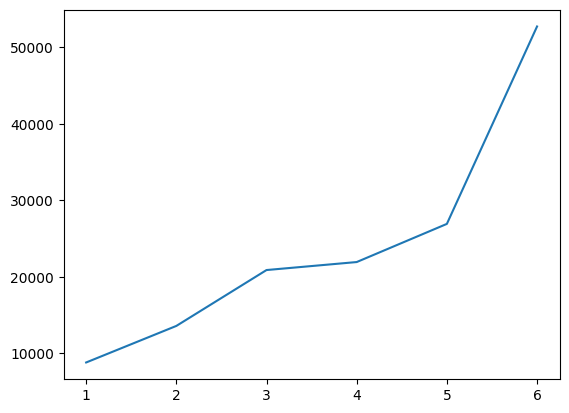

In [ ]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl_simplernn) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_simplernn)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

## Greedy search

In [ ]:
input_text='Vos '

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


'Vos  el vida de que de que de que de que'

## Beam Search

In [ ]:
input = "Cruel en el cartel,"
num_beams=10
num_words=6

### Estocástico

#### 1º pred

In [ ]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel en mi sueños en la hermano']
1:['cruel en el cartel en mi sueños en la marchándose']
2:['cruel en el cartel en mi sueños en te dulce']
3:['cruel en el cartel en mi sueños en te tanto']
4:['cruel en el cartel en no a que tu cuerpo']
5:['cruel en el cartel en no a que tu dudarlo']
6:['cruel en el cartel en no a que tu ojos']
7:['cruel en el cartel en mi sueños en la culebrones']
8:['cruel en el cartel en mi sueños en la viven']
9:['cruel en el cartel en mi sueños el vida que']


#### 2º pred *(verificar variabilidad)*

In [ ]:
# predicción con beam search (mismos parámetros)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel que la alma de por mismo']
1:['cruel en el cartel que la alma de por fue']
2:['cruel en el cartel que la alma de por ves']
3:['cruel en el cartel que la alma de por y']
4:['cruel en el cartel que la alma de por de']
5:['cruel en el cartel que la alma de por las']
6:['cruel en el cartel que la alma el voz en']
7:['cruel en el cartel que la alma el voz que']
8:['cruel en el cartel que la alma de sé en']
9:['cruel en el cartel que la alma de por en']


### Determinista

#### 1º pred

In [ ]:
# Cambiampos a modo de predicción 'det' (determinista)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='det')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel que que que que que de']
1:['cruel en el cartel que que que que que que']
2:['cruel en el cartel que que que que en de']
3:['cruel en el cartel que en que que que de']
4:['cruel en el cartel que que en que que de']
5:['cruel en el cartel que que que que que el']
6:['cruel en el cartel que que que que que en']
7:['cruel en el cartel que que que en que de']
8:['cruel en el cartel que que que que en que']
9:['cruel en el cartel que en que que que que']


#### 2º pred *(verificar variabilidad)*

In [ ]:
# predicción con beam search (mismos parámetros)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='det')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel que que que que que de']
1:['cruel en el cartel que que que que que que']
2:['cruel en el cartel que que que que en de']
3:['cruel en el cartel que en que que que de']
4:['cruel en el cartel que que en que que de']
5:['cruel en el cartel que que que que que el']
6:['cruel en el cartel que que que que que en']
7:['cruel en el cartel que que que en que de']
8:['cruel en el cartel que que que que en que']
9:['cruel en el cartel que en que que que que']


## Efecto de la temperatura

Se decide utilizar Beam Search Estocástico por ser el que ofreció mejores resultados.

**Función de la Temperatura (temp)**
* La temperatura se aplica a las probabilidades logarítmicas (`pred_large`) antes de pasarlas a la función `softmax`.
* `softmax(pred_large / temp)`: Esta operación escala las probabilidades logarítmicas dividiéndolas por `temp` y luego aplica la función `softmax` para obtener una distribución de probabilidad.
* Cuando `temp` es alto, las probabilidades se vuelven más uniformes, lo que resulta en una selección más aleatoria.
* Cuando `temp` es bajo, las probabilidades se vuelven más puntiagudas, lo que resulta en una selección más determinista (se favorecen las probabilidades más altas).
* En el caso de que `temp` sea 0, el programa daría un error de división por cero.

### Temp = 2

In [ ]:
temp = 2

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel muero todos todo del voz pretende']
1:['cruel en el cartel muero todos todo del voz muriendo']
2:['cruel en el cartel muero todos todo del hombre majestuosa']
3:['cruel en el cartel muero todos todo del hombre aumentes']
4:['cruel en el cartel muero todos todo del hombre borracho']
5:['cruel en el cartel muero todos todo del voz agente']
6:['cruel en el cartel muero todos todo del voz ¡“amurado”']
7:["cruel en el cartel muero todos todo del hombre e'caña"]
8:['cruel en el cartel muero todos todo del voz reinado']
9:['cruel en el cartel muero todos todo del hombre ebriedad']


### Temp = 3

In [ ]:
temp = 3

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel estos tabernas ya pesaba oír engañaste']
1:['cruel en el cartel estos tabernas ya llaman llorar rodean']
2:['cruel en el cartel estos tabernas ya llaman llorar tatuadas']
3:['cruel en el cartel estos tabernas ya ajuar revivo convicciones']
4:['cruel en el cartel estos tabernas ya pesaba oír apurada']
5:['cruel en el cartel estos tabernas ya juntos arremangado cigarros']
6:['cruel en el cartel estos tabernas ya ajuar revivo morir']
7:['cruel en el cartel estos tabernas ya ajuar “posta” atrevidas']
8:["cruel en el cartel estos tabernas ya ajuar laburito qu'en"]
9:['cruel en el cartel estos tabernas ya pesaba oír estío']


### Temp = 4

In [ ]:
temp = 4

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel viviremos escucharás dijeron peso maldigo virrey']
1:['cruel en el cartel ayacucho fariñera falles quién dé enteré']
2:['cruel en el cartel lagunas ¡y surcar comme procuraré preces']
3:['cruel en el cartel cosa aguantar dirijo hocicar puntillas… jamás']
4:['cruel en el cartel viviremos escucharás dijeron peso maldigo protocolo']
5:['cruel en el cartel lagunas ¡y surcar comme decile abuelita']
6:['cruel en el cartel viviremos escucharás dijeron peso enceguecida enseñó']
7:['cruel en el cartel lagunas ¡y surcar comme procuraré aplasta']
8:['cruel en el cartel ayacucho fariñera falles quién dé dantesca']
9:['cruel en el cartel lagunas ¡y surcar comme decile m’hijita']


### Temp = 6

In [ ]:
temp = 6

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel ninguna pude— vas una partió bijú']
1:['cruel en el cartel ninguna regeneración genuino gacho aguas derrumban']
2:['cruel en el cartel ninguna pude— parecido veces sonríen ensaladas']
3:['cruel en el cartel rato trabajito tuego “disparar encanao machotango']
4:['cruel en el cartel ninguna pude— vas una pelafustán felpudo']
5:['cruel en el cartel ninguna pude— vas una pelafustán gambetea']
6:['cruel en el cartel ninguna pude— ancló yacaré entró avaro']
7:['cruel en el cartel ninguna pude— vas una partió sensible']
8:['cruel en el cartel ninguna pude— ancló yacaré entró “vidurria”']
9:['cruel en el cartel ninguna regeneración genuino gacho aguas fruta']


### Temp = 8

In [ ]:
temp = 8

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel sólo quieras florean dando callejear inocencia']
1:['cruel en el cartel sólo quieras florean dando rompiéndose babas']
2:['cruel en el cartel oro entonces extasiado pasarla caso vidalita']
3:['cruel en el cartel sólo quieras irás salsa “adagio” ardiste']
4:['cruel en el cartel oro entonces extasiado pasarla caso sólo']
5:['cruel en el cartel oro entonces hallar” antillas atentas amuremos']
6:['cruel en el cartel oro entonces extasiado pasarla disquería broca']
7:['cruel en el cartel oro entonces extasiado pasarla caso lunas…']
8:['cruel en el cartel oro entonces hallar” antillas atentas migas']
9:['cruel en el cartel oro entonces hallar” antillas atorro pillos']


### Temp = 10

In [ ]:
temp = 10

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel insano ¡cha dichosa “al señal… dijeras']
1:['cruel en el cartel insano alumbre esconden dorado damiselas sumergida']
2:['cruel en el cartel insano ¡cha queja saldaste clásico raídas']
3:['cruel en el cartel insano ¡cha dichosa “al violas golpearnos']
4:['cruel en el cartel insano ¡cha dichosa “al pucherotes express']
5:['cruel en el cartel insano ¡cha queja saldaste clásico vamos']
6:['cruel en el cartel insano ¡cha dichosa “al pucherotes aplaude']
7:['cruel en el cartel insano ¡cha dichosa “al violas topé']
8:['cruel en el cartel insano ¡cha dichosa “al pucherotes saciaron']
9:['cruel en el cartel insano alumbre esconden ventana culto colores…']


### Temp = 20

In [ ]:
temp = 20

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel haraganera profecía ampara ¡padrino penetró mordedura']
1:['cruel en el cartel haraganera profecía ampara ¡padrino acariciada andariega']
2:['cruel en el cartel padeceres lona componen tiendita viejo musical']
3:['cruel en el cartel padeceres lona componen tiendita pesarosa malentendido']
4:['cruel en el cartel padeceres lona componen tiendita estar causó']
5:['cruel en el cartel padeceres lona componen tiendita viejo retrata']
6:['cruel en el cartel padeceres lona componen siembro fracasada cortejo']
7:['cruel en el cartel padeceres lona componen tiendita pesarosa incurable']
8:['cruel en el cartel haraganera profecía ampara ¡padrino penetró causarte']
9:['cruel en el cartel padeceres lona componen tiendita viejo peones']


### Temp = 50

In [ ]:
temp = 50

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel gastado ceñía nervioso ladraban colgando ¡mamá']
1:['cruel en el cartel gastado ceñía trabajándose “ciruja” altanera imagen']
2:['cruel en el cartel gastado ceñía locas último alumbraban moda']
3:['cruel en el cartel city recubriste achicar desesperes temblarás medialunas']
4:['cruel en el cartel city recubriste achicar prendieron culpa venerado']
5:['cruel en el cartel gastado ceñía locas último alumbraban alegramos']
6:['cruel en el cartel city recubriste achicar desesperes incumplidas juega']
7:['cruel en el cartel city recubriste achicar prendieron culpa molido']
8:['cruel en el cartel gastado ceñía trabajándose “ciruja” brebajes estrechamente']
9:['cruel en el cartel gastado ceñía nervioso ladraban arrancado pegados']


### Temp = 100

In [ ]:
temp = 100

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel caño pugliese pavana supertango orbe ¡llanto']
1:['cruel en el cartel campamento existían quedaré paje casarse barcito']
2:['cruel en el cartel caño pugliese carcajada dolor— honradez páginas']
3:['cruel en el cartel campamento existían quedaré prendo “chiquita conmovió']
4:['cruel en el cartel campamento existían quedaré prendo “chiquita palermo']
5:['cruel en el cartel caño pugliese carcajada dolor— honradez asesinado']
6:['cruel en el cartel campamento existían quedaré paje próxima guitarra']
7:['cruel en el cartel campamento existían quedaré paje gomía preciosa”']
8:['cruel en el cartel campamento existían quedaré paje casarse pausa']
9:['cruel en el cartel caño pugliese pavana supertango orbe alimentaban']


## Conclusiones parciales

**Método de búsqueda:**
- Greedy search no ofrece buenos resultados.
- Beam Search Estocástico entrega resultados más coherentes (con errores de género).
- Beam Search Determinista da resultados repetitivos (_"que que que…"_).

**Efecto de la temperatura:**
- Para temperaturas 2-3 se obtienen los mejores resultados.
- Tempreaturas mayores (entorno a 8) ya entregan secuencias de palabras más desconectadas entre sí.
- Temperaturas >10 dan un resultado más "azaroso". 

# LSTM

## Definir el modelo

In [ ]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 50)            │       1,227,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 24545)         │       2,479,045 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,847,095 (14.68 MB)

 Trainable params: 3,847,095 (14.68 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [ ]:
history_ppl = []
batch_size=512
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,batch_size=round(batch_size/8))], batch_size=batch_size)

--- Initializing PplCallback ---
Params: patience=10, batch_size=64, max_context_size=10, prediction_batch_size=64
Starting validation data preprocessing...
  Preprocessing sequence 100/11206...
  Preprocessing sequence 200/11206...
  Preprocessing sequence 300/11206...
  Preprocessing sequence 400/11206...
  Preprocessing sequence 500/11206...
  Preprocessing sequence 600/11206...
  Preprocessing sequence 700/11206...
  Preprocessing sequence 800/11206...
  Preprocessing sequence 900/11206...
  Preprocessing sequence 1000/11206...
  Preprocessing sequence 1100/11206...
  Preprocessing sequence 1200/11206...
  Preprocessing sequence 1300/11206...
  Preprocessing sequence 1400/11206...
  Preprocessing sequence 1500/11206...
  Preprocessing sequence 1600/11206...
  Preprocessing sequence 1700/11206...
  Preprocessing sequence 1800/11206...
  Preprocessing sequence 1900/11206...
  Preprocessing sequence 2000/11206...
  Preprocessing sequence 2100/11206...
  Preprocessing sequence 2200/112

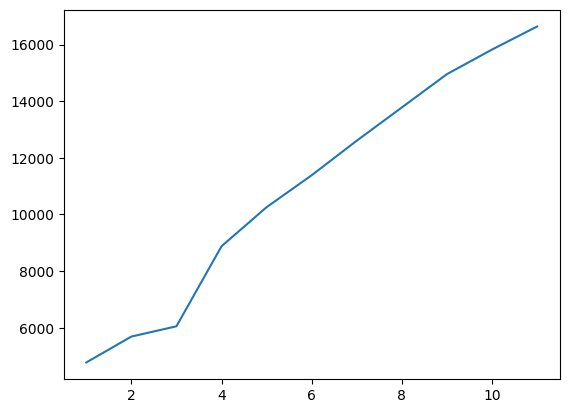

In [ ]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

## Greedy search

In [ ]:
input_text='Vos '

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


'Vos           '

## Beam Search

In [ ]:
input = "Cruel en el cartel,"
num_beams=10
num_words=6

### Estocástico

#### 1º pred

In [ ]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='sto')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 13)

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel de la la que la mujer']
1:['cruel en el cartel de la la que la de']
2:['cruel en el cartel de la la que la que']
3:['cruel en el cartel de la la que la']
4:['cruel en el cartel de la la que']
5:['cruel en el cartel de la la que']
6:['cruel en el cartel de la la que con en']
7:['cruel en el cartel de la la que la con']
8:['cruel en el cartel de la la que con ternura']
9:['cruel en el cartel de la la que el']


#### 2º pred *(verificar variabilidad)*

In [ ]:
# predicción con beam search (mismos parámetros)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel de las que un lo']
1:['cruel en el cartel de las que un los']
2:['cruel en el cartel de las que un la']
3:['cruel en el cartel de las que un']
4:['cruel en el cartel de tu mi de a llamarada']
5:['cruel en el cartel de tu mi de a mintiendo']
6:['cruel en el cartel de las que un a']
7:['cruel en el cartel de tu mi de el hace']
8:['cruel en el cartel de tu mi de un afán']
9:['cruel en el cartel de tu mi de el']


### Determinista

#### 1º pred

In [ ]:
# Cambiampos a modo de predicción 'det' (determinista)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='det')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 13)

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel']
1:['cruel en el cartel que']
2:['cruel en el cartel de']
3:['cruel en el cartel y']
4:['cruel en el cartel en']
5:['cruel en el cartel la']
6:['cruel en el cartel el']
7:['cruel en el cartel y']
8:['cruel en el cartel que']
9:['cruel en el cartel de']


#### 2º pred *(verificar variabilidad)*

In [ ]:
# predicción con beam search (mismos parámetros)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='det')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel']
1:['cruel en el cartel que']
2:['cruel en el cartel de']
3:['cruel en el cartel y']
4:['cruel en el cartel en']
5:['cruel en el cartel la']
6:['cruel en el cartel el']
7:['cruel en el cartel y']
8:['cruel en el cartel que']
9:['cruel en el cartel de']


## Efecto de la temperatura

Se decide utilizar Beam Search Estocástico por ser el que ofreció mejores resultados.

### Temp = 2

In [ ]:
temp = 2

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel copa di sonríen espero ¡levantarías ¡caricias']
1:['cruel en el cartel copa di sonríen espero malogra golpeaba']
2:['cruel en el cartel copa di sonríen espero impregna “taponazos”']
3:['cruel en el cartel copa di literarios dateró ya golondrinas']
4:['cruel en el cartel copa di sonríen espero malogra baches…']
5:['cruel en el cartel copa di sonríen espero impregna sobresaltos']
6:['cruel en el cartel copa di sonríen espero llorabas vergeles']
7:['cruel en el cartel copa di literarios dateró ya conquisté']
8:['cruel en el cartel copa di sonríen espero galope ¡revolviéndose']
9:['cruel en el cartel copa di sonríen espero tema prendido']


### Temp = 3

In [ ]:
temp = 3

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel alma hablarme mesa barrio alberio palcos']
1:['cruel en el cartel alma hablarme mesa barrio amplifica pondré']
2:['cruel en el cartel alma hablarme mesa barrio alberio ronca']
3:['cruel en el cartel alma hablarme mesa barrio cuide agresiva']
4:['cruel en el cartel alma hablarme mesa barrio ocultaba confiara']
5:['cruel en el cartel alma hablarme mesa barrio amplifica cornetas']
6:['cruel en el cartel alma hablarme mesa barrio cuide alsina']
7:['cruel en el cartel alma hablarme mesa barrio ocultaba pegados']
8:['cruel en el cartel alma hablarme mesa barrio ocultaba golpeaba']
9:['cruel en el cartel alma hablarme mesa barrio alberio matear']


### Temp = 4

In [ ]:
temp = 4

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel o queda quite robándole disiparse resucita']
1:['cruel en el cartel o queda manches muebles menega hacen']
2:['cruel en el cartel o queda manches muebles menega perro']
3:['cruel en el cartel o queda manches muebles menega suplicar']
4:['cruel en el cartel o queda quite vividas amuremos botella']
5:['cruel en el cartel o queda quite hacerme usés boleta']
6:['cruel en el cartel o queda quite hacerme usés acordar']
7:['cruel en el cartel o queda manches muebles menega apadrinó']
8:['cruel en el cartel o queda quite asco magaldi desde']
9:['cruel en el cartel o queda quite asco magaldi misho']


### Temp = 6

In [ ]:
temp = 6

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel heriste cálido rosales compadreaba balcarce gofio']
1:['cruel en el cartel heriste carreta facón acompañan esmero… junto']
2:['cruel en el cartel heriste carreta facón caminás fichaba delirante']
3:['cruel en el cartel heriste cálido rosales compadreaba barrillera vareador']
4:['cruel en el cartel heriste carreta facón caminás fichaba viendo']
5:['cruel en el cartel heriste carreta facón acompañan pedacito conjugaba']
6:['cruel en el cartel heriste carreta facón acompañan esmero… ayer']
7:['cruel en el cartel heriste cálido rosales compadreaba barrillera amargura']
8:['cruel en el cartel quebré adornando arrayán cañitas manubrio milonguera']
9:['cruel en el cartel cavernas chamuye bis hayamos sembraste derramé']


### Temp = 8

In [ ]:
temp = 8

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel canción asomaba volaron terca desperezan tenue']
1:['cruel en el cartel canción calmara fatídica barrio salieras para']
2:['cruel en el cartel canción asomaba volaron terca camisas liviano']
3:['cruel en el cartel canción calmara fatídica barrio dis rezbgado']
4:['cruel en el cartel canción bellezas anduvimos vislumbra empeñas segundos']
5:['cruel en el cartel canción calmara fatídica barrio salieras perdías']
6:['cruel en el cartel canción calmara fatídica barrio desenfunda alientan']
7:['cruel en el cartel canción asomaba volaron terca camisas pompa']
8:['cruel en el cartel canción asomaba amarro volante cuentos estudiadas']
9:['cruel en el cartel canción asomaba plumaje alcanza mecerán has']


### Temp = 10

In [ ]:
temp = 10

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel creía dolor… cancha’e rubor tosedoras periplo']
1:['cruel en el cartel motivos volcado destruimos cajones pasará… tardes']
2:['cruel en el cartel motivos felonía cordones esa bajas cribada']
3:['cruel en el cartel encierra tocame malogra nogal arregla jóvenes']
4:['cruel en el cartel creía pariendo extrañar rebosante tapete veranos']
5:['cruel en el cartel motivos volcado destruimos cajones león demasiados']
6:['cruel en el cartel creía dolor… cancha’e ocurrente puebleros puesto']
7:['cruel en el cartel encierra tocame malogra nogal honda juntas']
8:['cruel en el cartel creía dolor… cancha’e rubor tosedoras monarca']
9:['cruel en el cartel motivos volcado destruimos cajones león querubín']


### Temp = 20

In [ ]:
temp = 20

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel cinchás reinar mortaja capaz cartilla circundaban']
1:['cruel en el cartel cinchás reinar molinos olvidar odiosos chau']
2:['cruel en el cartel impertinente horizonte… envío quitado tempranas bailarlo']
3:['cruel en el cartel cinchás reinar molinos adormecer avejentado coquetas']
4:['cruel en el cartel impertinente horizonte… envío quitado ¿comprendes mostrado']
5:['cruel en el cartel cinchás reinar molinos olvidar odiosos presuroso']
6:['cruel en el cartel impertinente horizonte… envío quitado tempranas sumes']
7:['cruel en el cartel cinchás reinar mortaja capaz cartilla afrontó']
8:['cruel en el cartel reseca consigues diluvia ungido lagrimeaban ropa']
9:['cruel en el cartel impertinente horizonte… envío quitado ¿comprendes zamacueca']


Parece una letra de Spinetta *(es mi ídolo, no es una crítica jaja)*

### Temp = 50

In [ ]:
temp = 50

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel pasado… ¡yuyo rodeado condenados llenaro gambeteando']
1:['cruel en el cartel pasado… ¡yuyo rodeado condenados llenaro arroyito']
2:['cruel en el cartel pasado… ¡yuyo contenga bonelli escalofriado aleja']
3:['cruel en el cartel retoma idiota vamos llegao sospeché empujando']
4:['cruel en el cartel retoma idiota vamos llegao cumbre e']
5:['cruel en el cartel perfumado abrojos habilidad madam… sembrador empujan']
6:['cruel en el cartel perfumado abrojos habilidad envenenar sogno bambino']
7:['cruel en el cartel pasado… ¡yuyo rodeado condenados grabaste flashes']
8:['cruel en el cartel pasado… ¡yuyo contenga lanzando cuidó cotizan']
9:['cruel en el cartel pasado… ¡yuyo rodeado condenados llenaro beber']


### Temp = 100

In [ ]:
temp = 100

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel cobraré colilla compadrita mendigo vividos entrecortado']
1:['cruel en el cartel diria implorando vuelve loca— angelito consecuente']
2:['cruel en el cartel diria implorando quinquela entristezcas ofrecés entusiasmado']
3:['cruel en el cartel diria implorando vuelve loca— delirado ¡papito']
4:['cruel en el cartel cobraré colilla compadrita mendigo vividos garbo']
5:['cruel en el cartel diria implorando quinquela entristezcas ofrecés garfio']
6:['cruel en el cartel diria implorando vuelve loca— delirado senti']
7:['cruel en el cartel diria implorando vuelve prendería ¿por daguelé']
8:['cruel en el cartel diria implorando lana huequito afanes ansiaban']
9:['cruel en el cartel diria implorando quinquela entristezcas ofrecés arriesgada']


## Conclusiones parciales

**Método de búsqueda:**
- Greedy search no ofrece ningún resultado (todos espacios).
- Beam Search Estocástico entrega resultados repetitivo (_"de la la que la"_).
- Beam Search Determinista da resultados pobres, genera frases incompletas.

**Efecto de la temperatura:**
- En este caso, las temperaturas bajas dan resultados inservibles.
- Recién para temperaturas de 6-10 se obtienen los mejores resultados.
- Tempreaturas mayores (entorno a 20) generan secuencias de palabras interesantes pero desconectadas entre sí (efecto "Spinetta").

# LSTM c/Dropout

## Definir el modelo

In [ ]:
model = Sequential()

# la primera capa es de embedding entrenable.
# Recordar que se puede variar el tamaño del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 50)            │       1,227,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 32)            │           3,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 24545)         │         809,985 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,181,267 (8.32 MB)

 Trainable params: 2,181,267 (8.32 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
batch_size=512
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,batch_size=round(batch_size/8))], batch_size=batch_size)

--- Initializing PplCallback ---
Params: patience=10, batch_size=64, max_context_size=10, prediction_batch_size=64
Starting validation data preprocessing...
  Preprocessing sequence 100/11206...
  Preprocessing sequence 200/11206...
  Preprocessing sequence 300/11206...
  Preprocessing sequence 400/11206...
  Preprocessing sequence 500/11206...
  Preprocessing sequence 600/11206...
  Preprocessing sequence 700/11206...
  Preprocessing sequence 800/11206...
  Preprocessing sequence 900/11206...
  Preprocessing sequence 1000/11206...
  Preprocessing sequence 1100/11206...
  Preprocessing sequence 1200/11206...
  Preprocessing sequence 1300/11206...
  Preprocessing sequence 1400/11206...
  Preprocessing sequence 1500/11206...
  Preprocessing sequence 1600/11206...
  Preprocessing sequence 1700/11206...
  Preprocessing sequence 1800/11206...
  Preprocessing sequence 1900/11206...
  Preprocessing sequence 2000/11206...
  Preprocessing sequence 2100/11206...
  Preprocessing sequence 2200/112

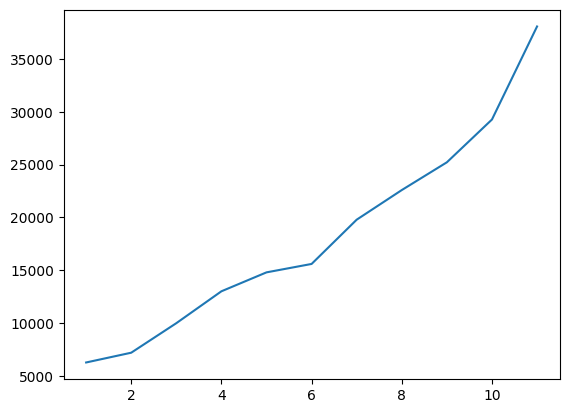

In [ ]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

## Greedy search

In [ ]:
input_text='Vos '

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'Vos  que que que que que que que que que que'

## Beam Search

In [ ]:
input = "Cruel en el cartel,"
num_beams=10
num_words=6

### Estocástico

#### 1º pred

In [ ]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='sto')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 13)

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel y tu a de la fe']
1:['cruel en el cartel y tu a de la soy']
2:['cruel en el cartel y tu a de te escuchar']
3:['cruel en el cartel y tu a de la compartí']
4:['cruel en el cartel y tu a de la el']
5:['cruel en el cartel y tu a de la con']
6:['cruel en el cartel y tu a de te lecho']
7:['cruel en el cartel y tu a de la dolor']
8:['cruel en el cartel y tu a de la un']
9:['cruel en el cartel y tu a de la verte']


#### 2º pred *(verificar variabilidad)*

In [ ]:
# predicción con beam search (mismos parámetros)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel las de de los te sufrir']
1:['cruel en el cartel las de de eso de bueno']
2:['cruel en el cartel las de de los el vida']
3:['cruel en el cartel las de de los con tu']
4:['cruel en el cartel las de de los el la']
5:['cruel en el cartel las de de sueños de no']
6:['cruel en el cartel las de de los con ¿qué']
7:['cruel en el cartel las de de los con no']
8:['cruel en el cartel las de de los el del']
9:['cruel en el cartel las de de los con mi']


### Determinista

#### 1º pred

In [ ]:
# Cambiampos a modo de predicción 'det' (determinista)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='det')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 13)

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel que que que que que que']
1:['cruel en el cartel que que que que que de']
2:['cruel en el cartel que que de que que que']
3:['cruel en el cartel de que que que que que']
4:['cruel en el cartel que que que de que que']
5:['cruel en el cartel que de que que que que']
6:['cruel en el cartel que que que que de que']
7:['cruel en el cartel que que de que que de']
8:['cruel en el cartel de que que que que de']
9:['cruel en el cartel que que que que de de']


#### 2º pred *(verificar variabilidad)*

In [ ]:
# predicción con beam search (mismos parámetros)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='det')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel que que que que que que']
1:['cruel en el cartel que que que que que de']
2:['cruel en el cartel que que de que que que']
3:['cruel en el cartel de que que que que que']
4:['cruel en el cartel que que que de que que']
5:['cruel en el cartel que de que que que que']
6:['cruel en el cartel que que que que de que']
7:['cruel en el cartel que que de que que de']
8:['cruel en el cartel de que que que que de']
9:['cruel en el cartel que que que que de de']


## Efecto de la temperatura

Se decide utilizar Beam Search Estocástico por ser el que ofreció mejores resultados.

### Temp = 2

In [ ]:
temp = 2

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel con ella saber fuerza caído ciber']
1:['cruel en el cartel ver su razón cien alma que']
2:['cruel en el cartel con ella saber fuerza muñecas desatinos']
3:['cruel en el cartel ver su razón cien alma iré']
4:['cruel en el cartel con ella saber fuerza hube mi']
5:['cruel en el cartel ver su razón cien alma puente']
6:['cruel en el cartel con ella saber fuerza caído guapeaste']
7:['cruel en el cartel ver su razón cien alma faltaran']
8:['cruel en el cartel ver su razón cien alma desapareció']
9:['cruel en el cartel con ella saber fuerza isla pasean']


### Temp = 3

In [ ]:
temp = 3

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel mugriento pibes penar… esto nenes convivir']
1:['cruel en el cartel discursos convertido mirones contaré voluptuoso calculan']
2:['cruel en el cartel mugriento pibes penar… esto nenes bonanza']
3:['cruel en el cartel mugriento pibes penar… esto nenes caché']
4:['cruel en el cartel discursos convertido flota abrirse dejá rantifusa']
5:['cruel en el cartel mugriento pibes penar… esto nenes banquero']
6:['cruel en el cartel discursos convertido mirones contaré voluptuoso hiera']
7:['cruel en el cartel mugriento pibes penar… esto genio joda']
8:['cruel en el cartel discursos convertido flota mozos abeja murga']
9:['cruel en el cartel mugriento pibes penar… esto nenes mojen']


### Temp = 4

In [ ]:
temp = 4

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel las moza prejuicios derechos mariposa náufrago']
1:['cruel en el cartel las ese minas sobran videos galas']
2:['cruel en el cartel las moza prejuicios derechos mariposa amarse']
3:['cruel en el cartel las ese minas sobran bayos trabajarla']
4:['cruel en el cartel las ese minas sobran bayos angostas']
5:['cruel en el cartel las moza prejuicios derechos mariposa conseguir']
6:['cruel en el cartel las ese minas sobran videos turbión']
7:['cruel en el cartel las moza prejuicios derechos mariposa entusiasmo']
8:['cruel en el cartel las cercanas… ardían dejaste afiche mismos']
9:['cruel en el cartel las moza prejuicios dormías protagonista copé']


### Temp = 6

In [ ]:
temp = 6

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel traza mismo guante envidiar abates balón']
1:['cruel en el cartel emoción socorro descartar quedamos cadencia apoderara']
2:['cruel en el cartel emoción socorro descartar quedamos cadencia mandamientos']
3:['cruel en el cartel sport rescatalo voy matizan lastiman torturadas']
4:['cruel en el cartel emoción sarpado empezará salió antiguos afuera']
5:['cruel en el cartel sport rescatalo voy giacumín brotaban supliqués']
6:['cruel en el cartel sport rescatalo voy giacumín record ¡sangro']
7:['cruel en el cartel emoción socorro descartar quedamos cadencia tachita']
8:['cruel en el cartel emoción sarpado empezará salió antiguos desesperes']
9:['cruel en el cartel sport rescatalo voy giacumín record esfumó']


### Temp = 8

In [ ]:
temp = 8

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel cuchillo dis comer negado crucecita atardeció']
1:['cruel en el cartel seguir maletín estoy torrentes disfrazando mareo']
2:['cruel en el cartel seguir orilla pura pasan malandras sembrame']
3:['cruel en el cartel seguir orilla crepúsculo ¡mentime… luceros primaveral']
4:['cruel en el cartel seguir orilla pura pasan nosocomio abortar']
5:['cruel en el cartel seguir orilla pura pasan nosocomio necesario']
6:['cruel en el cartel cuchillo dis comer negado crucecita soda']
7:['cruel en el cartel seguir orilla crepúsculo terminaron consentí cambrona']
8:['cruel en el cartel seguir orilla crepúsculo terminaron consentí marchando']
9:['cruel en el cartel seguir maletín estoy torrentes disfrazando vengaré']


### Temp = 10

In [ ]:
temp = 10

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel único abonos disfrazado diluvia migajas lanto']
1:["cruel en el cartel único abonos disfrazado diluvia j'ai despacito"]
2:['cruel en el cartel único ahondar mateadas humillaba ensayando encurdelada']
3:['cruel en el cartel único abonos disfrazado diluvia confesarte pregón']
4:['cruel en el cartel durmieron guadaña compadezcas aferraría llenó colón”']
5:['cruel en el cartel único bates íntimo morir mañero peón']
6:['cruel en el cartel único ahondar mateadas vibran deshicieron dentista']
7:['cruel en el cartel único abonos disfrazado diluvia confesarte creciste']
8:["cruel en el cartel único abonos disfrazado diluvia j'ai pejerrey"]
9:['cruel en el cartel único bates íntimo morir mañero tiernos']


### Temp = 20

In [ ]:
temp = 20

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel spee orquestas infames teclas borra bicoca']
1:['cruel en el cartel forfait metieron dique niñas inundan estudiantil']
2:['cruel en el cartel sirva perdido… encantos matreros morochas aparecer']
3:['cruel en el cartel sirva perdido… amanecer empeño yobaca olor']
4:['cruel en el cartel sirva perdido… faltaron invitar concentrás cheque']
5:['cruel en el cartel 2005 sagradas fosforescentes choca uspallata fueyes']
6:['cruel en el cartel spee orquestas infames teclas entendés dibello']
7:['cruel en el cartel sirva perdido… encantos matreros morochas dobló']
8:['cruel en el cartel 2005 sagradas fosforescentes choca uspallata tarará']
9:['cruel en el cartel forfait metieron dique niñas inundan zumbón']


### Temp = 50

In [ ]:
temp = 50

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel betinotti acción rodera ¡carreras renuevas grilo']
1:['cruel en el cartel traperos eco ahogara trizas… ¿donde entregaba']
2:['cruel en el cartel lánguido entreguen d’esos retobármele pregúntele argentina']
3:['cruel en el cartel pliegues ventura hago mischia tenías tuntún']
4:['cruel en el cartel traperos eco ahogara trizas… quebraba cáliz']
5:['cruel en el cartel pliegues diez voy… quemándote azotar palpité']
6:['cruel en el cartel traperos eco ahogara trizas… quebraba busqué']
7:['cruel en el cartel pernós formaron mangar agitaste chupar revoir']
8:['cruel en el cartel traperos eco ahogara trizas… quebraba pagaré']
9:['cruel en el cartel lánguido mein ruego avecita manchen diosas']


### Temp = 100

In [ ]:
temp = 100

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel musitando consagración pegaba arremangado musicante camaradas']
1:['cruel en el cartel gen coperos “yugar” presentir endulzar recorriste']
2:['cruel en el cartel gen coperos “yugar” maragata ¡pelito sutil']
3:['cruel en el cartel gen coperos “yugar” presentir endulzar rebelarme']
4:['cruel en el cartel gen coperos “yugar” presentir endulzar arte']
5:['cruel en el cartel musitando consagración pegaba arremangado musicante ¡sonaste']
6:['cruel en el cartel aflija hería trensillera ¡andá suenan chairaban']
7:['cruel en el cartel gen coperos “yugar” presentir endulzar resucitando']
8:['cruel en el cartel labura intemperie preví contesto brasil perfil']
9:['cruel en el cartel gen coperos “yugar” maragata ¡pelito tendrán']


## Conclusiones parciales

**Método de búsqueda:**
- Greedy search no ofrece buenos resultados (_"que que que…"_).
- Beam Search Estocástico entrega resultados más coherentes, pero sigue siendo muy repetitivo (_"las de de los"_).
- Beam Search Determinista da resultados repetitivos (_"que que que…"_).

**Efecto de la temperatura:**
- Ya con temperatura 2 ofrece un mejor resultado.
- En este caso, entre 3 y 4 se obtienen los mejores resultados.
- Tempreaturas mayores (entorno a 6) generan secuencias de palabras más desconectadas entre sí.

# GRU

## Definir el modelo

In [ ]:
# GATED RECURRENT UNITS (GRU)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model_gru = Sequential()

# Capa de embedding entrenable
model_gru.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model_gru.add(GRU(100, return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(100, return_sequences=True))
model_gru.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
model_gru.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica
model_gru.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 50)            │       1,227,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 100)           │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, None, 100)           │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 32)            │           3,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 24545)         │         809,985 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,146,667 (8.19 MB)

 Trainable params: 2,146,667 (8.19 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [ ]:
history_ppl_gru = []
batch_size=512
hist_gru = model_gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_gru,batch_size=round(batch_size/8))], batch_size=batch_size)

--- Initializing PplCallback ---
Params: patience=5, batch_size=64, max_context_size=7, prediction_batch_size=64
Starting validation data preprocessing...
  Preprocessing sequence 100/11206...
  Preprocessing sequence 200/11206...
  Preprocessing sequence 300/11206...
  Preprocessing sequence 400/11206...
  Preprocessing sequence 500/11206...
  Preprocessing sequence 600/11206...
  Preprocessing sequence 700/11206...
  Preprocessing sequence 800/11206...
  Preprocessing sequence 900/11206...
  Preprocessing sequence 1000/11206...
  Preprocessing sequence 1100/11206...
  Preprocessing sequence 1200/11206...
  Preprocessing sequence 1300/11206...
  Preprocessing sequence 1400/11206...
  Preprocessing sequence 1500/11206...
  Preprocessing sequence 1600/11206...
  Preprocessing sequence 1700/11206...
  Preprocessing sequence 1800/11206...
  Preprocessing sequence 1900/11206...
  Preprocessing sequence 2000/11206...
  Preprocessing sequence 2100/11206...
  Preprocessing sequence 2200/11206

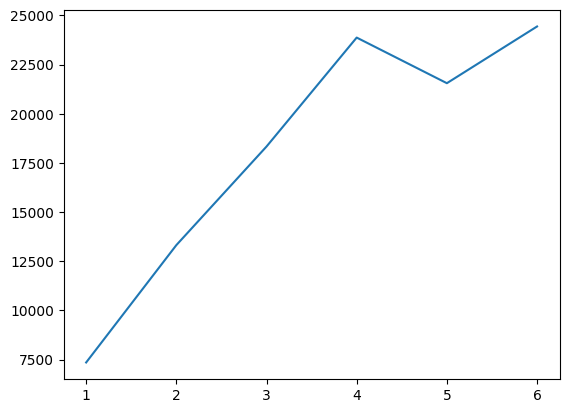

In [ ]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl_gru) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_gru)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

## Greedy search

In [ ]:
input_text='Vos '

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


'Vos  que que que que que que que que que que'

## Beam Search

In [ ]:
input = "Cruel en el cartel,"
num_beams=10
num_words=6

### Estocástico

#### 1º pred

In [ ]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel de las vez en a vi']
1:['cruel en el cartel de las vez en a 2011']
2:['cruel en el cartel de las vez en a hablan']
3:['cruel en el cartel de las vez en a en']
4:['cruel en el cartel de las vez en a los']
5:['cruel en el cartel de las sol de la dateró']
6:['cruel en el cartel de las vez en a un']
7:['cruel en el cartel de las sol de mis sed']
8:['cruel en el cartel de las vez en a y']
9:['cruel en el cartel de las sol de la vos']


#### 2º pred *(verificar variabilidad)*

In [ ]:
# predicción con beam search (mismos parámetros)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel que que de de una tango']
1:['cruel en el cartel que que que a los estrellas']
2:['cruel en el cartel que que que de es y']
3:['cruel en el cartel que que que de ahora si']
4:['cruel en el cartel que que de de las fondo']
5:['cruel en el cartel que que que de es lo']
6:['cruel en el cartel que que de de una hablando']
7:['cruel en el cartel que que que a los molinos']
8:['cruel en el cartel que que que de es la']
9:['cruel en el cartel que que que a los fe']


### Determinista

#### 1º pred

In [ ]:
# Cambiampos a modo de predicción 'det' (determinista)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='det')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel que que que que que que']
1:['cruel en el cartel que que que que que de']
2:['cruel en el cartel que que que que en que']
3:['cruel en el cartel que que que en que que']
4:['cruel en el cartel que que en que que que']
5:['cruel en el cartel que en que que que que']
6:['cruel en el cartel en que que que que que']
7:['cruel en el cartel que que que en que de']
8:['cruel en el cartel que que en que que de']
9:['cruel en el cartel que en que que que de']


#### 2º pred *(verificar variabilidad)*

In [ ]:
# predicción con beam search (mismos parámetros)
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=1,mode='det')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel que que que que que que']
1:['cruel en el cartel que que que que que de']
2:['cruel en el cartel que que que que en que']
3:['cruel en el cartel que que que en que que']
4:['cruel en el cartel que que en que que que']
5:['cruel en el cartel que en que que que que']
6:['cruel en el cartel en que que que que que']
7:['cruel en el cartel que que que en que de']
8:['cruel en el cartel que que en que que de']
9:['cruel en el cartel que en que que que de']


## Efecto de la temperatura

Se decide utilizar Beam Search Estocástico por ser el que ofreció mejores resultados.

### Temp = 2

In [ ]:
temp = 2

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel esquina ensueño noche hay la portador']
1:['cruel en el cartel esquina ensueño noche hay la amor']
2:['cruel en el cartel esquina ensueño noche flor a marcelo']
3:['cruel en el cartel esquina ensueño noche cosas cielo fleitas']
4:['cruel en el cartel esquina ensueño noche hay la surgiendo']
5:['cruel en el cartel esquina ensueño noche flor a estrofa']
6:['cruel en el cartel esquina ensueño noche hay la mí”']
7:['cruel en el cartel esquina ensueño noche flor a olvidar']
8:['cruel en el cartel esquina ensueño noche hay la isidro']
9:['cruel en el cartel esquina ensueño noche flor sin boxeador']


### Temp = 3

In [ ]:
temp = 3

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel años fórmula un suerte cultura que']
1:['cruel en el cartel años fórmula un suerte tienen arde']
2:['cruel en el cartel años fórmula un suerte tienen burlen']
3:['cruel en el cartel años fórmula un comenzó san descolgar']
4:['cruel en el cartel años fórmula un organito tranway cual']
5:['cruel en el cartel años fórmula un suerte tienen confiándole']
6:['cruel en el cartel años fórmula un comenzó san “pucheros”']
7:['cruel en el cartel años fórmula un comenzó san bravucón']
8:['cruel en el cartel años fórmula un suerte tienen veía']
9:['cruel en el cartel años fórmula un organito pisotones cantina']


### Temp = 4

In [ ]:
temp = 4

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel cambio torna nuevo a salgo comarca']
1:['cruel en el cartel cambio torna nuevo a regresa húmedo']
2:['cruel en el cartel cambio torna nuevo a regresa acostumbrado']
3:['cruel en el cartel cambio torna nuevo a palo pimpollos']
4:['cruel en el cartel cambio torna nuevo a curarte hoy']
5:['cruel en el cartel cambio torna nuevo a ¡maldita campaneala']
6:['cruel en el cartel cambio torna nuevo a curarte remosaré']
7:['cruel en el cartel cambio torna nuevo a salgo extrañaría']
8:['cruel en el cartel cambio torna nuevo a curarte horcón']
9:['cruel en el cartel cambio torna nuevo a palo tema']


### Temp = 6

In [ ]:
temp = 6

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel sonreía puñalada soga bagaje orfeo cornetas']
1:['cruel en el cartel ¿lloras encorvado mago salú reconocen campoamor']
2:['cruel en el cartel ¿lloras encorvado mago negar lección… perro']
3:['cruel en el cartel ¿lloras encorvado mago negar lección… banderas']
4:['cruel en el cartel sonreía puñalada soga bagaje orfeo galana']
5:['cruel en el cartel sonreía puñalada soga bagaje adusto vals']
6:['cruel en el cartel ¿lloras encorvado mago salú imprudencias tú…']
7:['cruel en el cartel ¿lloras encorvado mago salú imprudencias soñarlos']
8:['cruel en el cartel ¿lloras encorvado mago negar lección… penetrante']
9:['cruel en el cartel ¿lloras encorvado mago salú imprudencias traviesos']


### Temp = 8

In [ ]:
temp = 8

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel si alcahueta embalado estremecen pensará querencias']
1:['cruel en el cartel entrá guitarreadas situación ¡solo cuando concursos']
2:['cruel en el cartel si alcahueta embalado estremecen pensará destinada']
3:['cruel en el cartel tu mateo marieta exhausto cierzo consagrarse']
4:['cruel en el cartel si alcahueta embalado estremecen pensará arrasar']
5:['cruel en el cartel tu mateo marieta exhausto cierzo arrodillarte']
6:['cruel en el cartel entrá guitarreadas situación ¡solo cuando imponente']
7:['cruel en el cartel si alcahueta embalado refinao luna frac']
8:['cruel en el cartel tu mateo marieta mimoso mecía morían']
9:['cruel en el cartel si alcahueta embalado estremecen reite juras']


### Temp = 10

In [ ]:
temp = 10

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel sepa ¡guapo tremendas reflejos eternas esquena']
1:['cruel en el cartel sepa ¡entraste dura marco residente sueños']
2:['cruel en el cartel sepa ¡entraste dura marco residente delatora']
3:['cruel en el cartel sepa ¡entraste despliegan acurruqué filo rosadas']
4:['cruel en el cartel sepa ¡guapo tremendas reflejos eternas tempranera']
5:['cruel en el cartel sepa ¡entraste dura marco balde v']
6:['cruel en el cartel sepa ¡guapo tremendas reflejos granate esparcida']
7:['cruel en el cartel sepa ¡entraste despliegan acurruqué filo hundiéndose']
8:['cruel en el cartel sepa ¡entraste dura marco sur llegaría']
9:['cruel en el cartel sepa ¡entraste dura criaron abusé ruinas']


### Temp = 20

In [ ]:
temp = 20

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel rola cana da antillas trasnochando añorando']
1:['cruel en el cartel rola cana da antillas pain purifica']
2:['cruel en el cartel rola cana da antillas hacíame colilla']
3:['cruel en el cartel pego ¿para veredas sepultar achicao prodigio']
4:['cruel en el cartel pego ¿para veredas sepultar achicao cruzarte']
5:['cruel en el cartel toulouse venero ¿de rajamos versitos glamorosa']
6:['cruel en el cartel pego ¿para veredas sepultar obligo arrodillado']
7:['cruel en el cartel rola cana da antillas pain ordenados']
8:['cruel en el cartel pego ¿para veredas sepultar obligo ahogue']
9:['cruel en el cartel toulouse venero ¿de rajamos versitos dejastes']


### Temp = 50

In [ ]:
temp = 50

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel y desazón divertirme despedí chuño traigan']
1:['cruel en el cartel y desazón divertirme despedí evoluciones comen']
2:['cruel en el cartel y desazón divertirme despedí evoluciones hispanos']
3:['cruel en el cartel y desazón divertirme despedí chuño cariños']
4:['cruel en el cartel y desazón divertirme malgré cortarse gorjeo']
5:['cruel en el cartel y desazón divertirme malgré fibras lástima']
6:['cruel en el cartel y encantado trot impudor abominable buscadas']
7:['cruel en el cartel y desazón divertirme malgré fibras alumbrado']
8:['cruel en el cartel y desazón divertirme malgré cortarse apretada']
9:['cruel en el cartel y desazón divertirme despedí evoluciones carambola']


### Temp = 100

In [ ]:
temp = 100

In [ ]:
# predicción con beam search (mismos parámetros 'sto')
salidas = beam_search(model,num_beams=num_beams,num_words=num_words,input=input,temp=temp,mode='sto')

In [ ]:
# Todas las salidas
for i in range(num_beams):
  print(i,decode(salidas[i]), sep=":")

0:['cruel en el cartel mejorar golpeó compañía lagunas arregla cada']
1:['cruel en el cartel recorren cachar sospecha ¡salvame conciente hermosura']
2:['cruel en el cartel mejorar golpeó malicia reir renacido alargan']
3:['cruel en el cartel mejorar golpeó malicia reir renacido coty']
4:['cruel en el cartel mejorar golpeó compañía sudados esquivés carabela']
5:['cruel en el cartel mejorar golpeó compañía lagunas arregla fragor']
6:['cruel en el cartel mejorar golpeó malicia reir renacido dónde']
7:['cruel en el cartel recorren cachar sospecha ¡salvame conciente dichas']
8:['cruel en el cartel mejorar golpeó compañía profecía aprovechó crudo']
9:['cruel en el cartel mejorar golpeó compañía sudados esquivés enredó']


## Conclusiones parciales

**Método de búsqueda:**
- Greedy search no ofrece buenos resultados (_"que que que…"_).
- Beam Search Estocástico entrega resultados más coherentes (aunque sigue siendo muy repetitivo).
- Beam Search Determinista da resultados repetitivos (_"que que que…"_).

**Efecto de la temperatura:**
- Para temperaturas 2-3 se obtienen los mejores resultados, pero no terminan de ser satisfactorios.
- Tempreaturas mayores a 8 entregan secuencias de palabras desconectadas entre sí.
- Temperaturas >20 dan un resultado más "azaroso". 

# Conclusiones generales

- El tamaño del corpus es crítico ya que puede incrementar significativamente las exigencias de recursos computacionales.
- Todos los entrenamientos se interrumpieron en menos de 20 epochs por no lograr reducir la preplejidad durante el entrenamiento.

**Método de búsqueda:**
- **Greedy search:** en ningún caso dio buenos resultados, siendo el peor método.
- **Beam Search Estocástico:** aportó los resultados más coherentes, especialmente para temperaturas > 3.
- **Beam Search Determinista:** entregaba resultados muy repetitivos (_"que que que…"_).

**Efecto de la temperatura:**
- Temp. 1 suele dar un mal resultado, con mucha repetición de los términos más probables.
- Entre 2 a 4 se obtienen resultados más coherentes.
- Entorno a 6/8 se consigue el "Efecto Spinetta".
- Temperaturas >10 dan un resultado más "azaroso". 


**Ranking de Algoritmos _(100% subjetivo)_:**
1. **GRU:** no termina de dar buenos resultados para ninguna temperatura.
1. **LSTM c/Dropout:** da resultados con cierta coherencia pero tienden a ser términos desconectados.
1. **Celda de Elman:** ajustando la temperatura, se obtienen mejores resultados desde la sintaxis.
1. **LSTM:** particularmente, es el que da los resultados que más me gustaron para todos los valores de temperatura.

**ACLARACIÓN:**

Dada la gran cantidad de problemas que fui encontrando durante el desarrollo de este desafío y las modificaciones al código base que tuve que realizar para lograr que los entrenamientos se completaran, **no estoy realmente seguro de si los resultados obtenidos son "esperables"** (dependiendo del corpus y arquitecturas elegidas) o son subóptimos y son el resultado de algún error cometido en el armado del código.